In [ ]:
#| default_exp eval

In [ ]:
#| export
import logging as l

import torch

from looped_experiments.all import *

In [ ]:
#| export
class MetricsCB(Callback):
    def __init__(self, metric_fn): self.metric_fn = metric_fn
    def before_fit(self, _): self.metrics = []

    def after_batch(self, learn):
        self.metrics.append(to_cpu(self.metric_fn(learn.preds, learn.yb)))

    def after_epoch(self, learn):
        try:
            self.metrics = torch.cat(self.metrics)
        except TypeError:
            l.warning("Was not able to concatenate metrics")
            pass

In [ ]:
#| export
def squared_error(preds, ys):
    return (preds - ys).square()

In [ ]:
#| export
def eval(cfg, model_path=None):
    train = cfg.training
    task = get_task_cls(cfg.task.task_name)(train.batch_size, **cfg.task)
    dl_eval = dataloader(task, train.eval_steps)

    @FnCallback("before_batch")
    def trans_input(learner): learner.xb = (learner.xb, learner.yb)

    model = get_model(cfg.model)
    weights = torch.load(model_path or cfg.out_dir / "model_last.pt", weights_only=True)
    if '+train' in str(model_path): weights = weights['model_state_dict']
    model.load_state_dict(weights)
    loss_fn = get_loss(cfg.model)
    metric_cb = MetricsCB(squared_error)
    cbs = [ToDeviceCB(), trans_input, metric_cb]
    Learner(model, None, dl_eval, None, loss_fn=loss_fn, cbs=cbs).eval()
    return metric_cb.metrics

In [ ]:
eval_overrides = ["training.batch_size=256", "training.eval_steps=20", "task.n_points=41"]

## Get runs

In [ ]:
from looped_experiments.wandb_utils import get_runs

In [ ]:
base = get_config()
runs = get_runs(base.wandb.project)

In [ ]:
clm_runs = {}
for r in runs:
    cfg_m = r.config['model']
    if cfg_m['family']=="gpt2_loop" \
        and r.state != 'running' \
        and 'curriculum' in cfg_m \
        and 'type' in cfg_m['curriculum']['loops']:
        clm_runs[r.name]=r

In [ ]:
from pathlib import Path

In [ ]:
errs = {}
for k, v in clm_runs.items():
    cfg = get_config(cfg_dict=v.config, overrides=eval_overrides)
    loc = Path("../"+v.config['out_dir'])
    loc = loc/'model_last.pt' if (loc/'model_last.pt').exists() else loc/'model_90000+train.pt'
    errs[k] = eval(cfg, loc) 

In [ ]:
#| export
def aggregate_metrics(result_dict, non_truncated_dims, bootstrap_trials=1000):
    """
    Takes as input a tensor of shape (num_eval, n_points) and returns a dict with
    per-point mean, stddev, and bootstrap limits
    """
    d = non_truncated_dims
    results = {}
    for model_name in result_dict.keys():
        errs = result_dict[model_name]
        tmp = {}
        tmp["mean"] = errs.mean(0) / d
        tmp["std"] = errs.std(0, unbiased=True) / d
        n = len(errs)
        bootstrap_indices = torch.randint(n, size=(bootstrap_trials, n))
        bootstrap_means = errs[bootstrap_indices].mean(dim=1).sort(dim=0)[0]
        tmp["bootstrap_low"] = bootstrap_means[int(0.05 * bootstrap_trials), :] / d
        tmp["bootstrap_high"] = bootstrap_means[int(0.95 * bootstrap_trials), :] / d
        results[model_name] = tmp

    return results

In [ ]:
res = aggregate_metrics(errs, cfg.task.n_dims)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

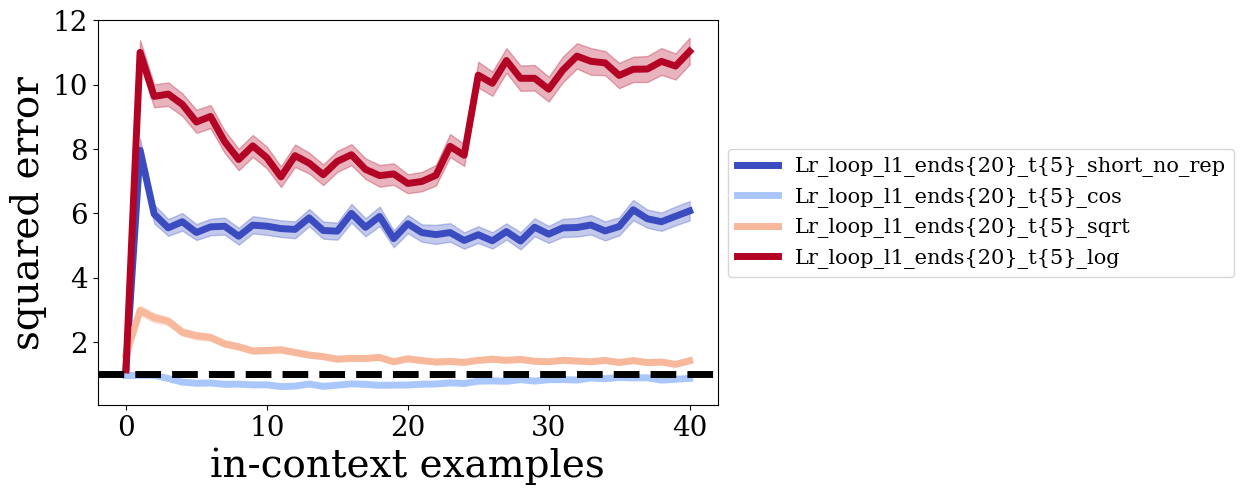

In [ ]:

fig_hparam = {
    'figsize': (8, 5),
    'labelsize': 28,
    'ticksize': 20,
    'linewidth': 5,
    'fontsize': 15,
    'titlesize': 20,
    'markersize': 15
}

# font specification
fontdict = {'family': 'serif',
            'size': fig_hparam['fontsize'],
            }

fig, ax = plt.subplots(1, figsize=fig_hparam['figsize'])

err_result_dict_agg = res

cmap = plt.get_cmap("coolwarm")
result_name_list = errs.keys()
colors = cmap(np.linspace(0, 1, len(result_name_list)))
for idx, model_name in enumerate(result_name_list):
    err = err_result_dict_agg[model_name]["mean"]
    ax.plot(err, color=colors[idx], lw=fig_hparam['linewidth'], label=model_name.capitalize())
    low = err_result_dict_agg[model_name]["bootstrap_low"]
    high = err_result_dict_agg[model_name]["bootstrap_high"]
    ax.fill_between(range(len(low)), low, high, alpha=0.3, color=colors[idx])

ax.tick_params(axis='both', labelsize=fig_hparam['ticksize'])
ax.axhline(1, color='k', ls='--', lw=fig_hparam['linewidth'])
# ax.set_ylim(-0.1, 1.25)
# plt.xticks(np.arange(0, n_points))
plt.rc('font', family='serif')
ax.set_xlabel("in-context examples", fontsize=fig_hparam['labelsize'])
y_label = ax.set_ylabel("squared error", fontsize=fig_hparam['labelsize'])
legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=fig_hparam['fontsize'])

# plt.savefig("result_folder/Figures/LR_err.pdf", format='pdf', dpi=600, bbox_inches='tight')

In [ ]:
res['LR_loop_L1_ends{20}_T{5}_cos']

{'mean': tensor([0.9565, 0.9635, 0.9620, 0.8666, 0.7526, 0.7175, 0.7252, 0.6848, 0.6900,
         0.6676, 0.6690, 0.6136, 0.6287, 0.6943, 0.6213, 0.6580, 0.6994, 0.6837,
         0.6521, 0.6597, 0.6632, 0.6867, 0.6946, 0.7307, 0.7103, 0.7815, 0.7906,
         0.7786, 0.8298, 0.7845, 0.8291, 0.8296, 0.8175, 0.8820, 0.8593, 0.8964,
         0.8837, 0.8887, 0.8140, 0.8403, 0.8689]),
 'std': tensor([1.5125, 1.5432, 1.7529, 1.3746, 1.2689, 1.1635, 1.2735, 1.3641, 1.2416,
         1.1061, 1.2592, 1.1529, 1.0386, 1.1678, 1.0993, 1.1273, 1.2089, 1.2063,
         1.1213, 1.1258, 1.1108, 1.2040, 1.1456, 1.2751, 1.2359, 1.3062, 1.3327,
         1.4487, 1.4966, 1.3270, 1.3666, 1.3686, 1.4158, 1.5551, 1.3992, 1.5040,
         1.5364, 1.5264, 1.3569, 1.4112, 1.4534]),
 'bootstrap_low': tensor([0.9090, 0.9104, 0.9031, 0.8216, 0.7147, 0.6806, 0.6858, 0.6408, 0.6479,
         0.6319, 0.6303, 0.5787, 0.5954, 0.6562, 0.5852, 0.6231, 0.6573, 0.6470,
         0.6164, 0.6231, 0.6274, 0.6470, 0.6588, 0.6883,